 ## 5b. Aprendizaje por transferencia


Hasta ahora, hemos entrenado modelos precisos en grandes conjuntos de datos, y también hemos descargado un modelo preentrenado que hemos utilizado sin necesidad de entrenamiento. Pero, ¿y si no podemos encontrar un modelo preentrenado que haga exactamente lo que necesitamos, y si no disponemos de un conjunto de datos lo suficientemente grande como para entrenar un modelo desde cero? En este caso, hay una técnica muy útil que podemos utilizar y que se llama [aprendizaje por transferencia](https://blogs.nvidia.com/blog/2019/02/07/what-is-transfer-learning/).
Con el aprendizaje por transferencia, tomamos un modelo preentrenado y lo volvemos a entrenar en una tarea que tiene cierto solapamiento con la tarea de entrenamiento original. Una buena analogía es la de un artista experto en un medio, como la pintura, que quiere aprender a practicar otro medio, como el dibujo a carboncillo. Podemos imaginar que las habilidades que aprendieron mientras pintaban serían muy valiosas para aprender a dibujar con carboncillo.
Como ejemplo en aprendizaje profundo, digamos que tenemos un modelo pre-entrenado que es muy bueno reconociendo diferentes tipos de coches, y queremos entrenar un modelo para reconocer tipos de motocicletas. Muchos de los aprendizajes del modelo de coche serían probablemente muy útiles, por ejemplo la capacidad de reconocer faros y ruedas.
El aprendizaje por transferencia es especialmente potente cuando no disponemos de un conjunto de datos amplio y variado. En este caso, un modelo entrenado desde cero probablemente memorizaría los datos de entrenamiento rápidamente, pero no sería capaz de generalizar bien a nuevos datos. Con el aprendizaje por transferencia, puede aumentar sus posibilidades de entrenar un modelo exacto.

## 5b.1 Objetivos

* Preparar un modelo preentrenado para el aprendizaje de transferencia
* Realiza el aprendizaje de transferencia con tu propio conjunto de datos en un modelo preentrenado.
* Afinar aún más el modelo para obtener mejores resultados.


In [ ]:
!wget https://github.com/ichaparroc/IA-EPIS/raw/refs/heads/main/FDL_5b.zip
!unzip FDL_5b.zip

--2025-05-02 22:05:52--  https://github.com/ichaparroc/IA-EPIS/raw/refs/heads/main/FDL_5b.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ichaparroc/IA-EPIS/refs/heads/main/FDL_5b.zip [following]
--2025-05-02 22:05:52--  https://raw.githubusercontent.com/ichaparroc/IA-EPIS/refs/heads/main/FDL_5b.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12041993 (11M) [application/zip]
Saving to: ‘FDL_5b.zip’

FDL_5b.zip          100%[===================>]  11.48M  --.-KB/s    in 0.1s    

2025-05-02 22:05:53 (93.8 MB/s) - ‘FDL_5b.zip’ saved [12041993/12041993]

Archive:  FDL_5b.zip
   creating: tr

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io

import glob
import json
from PIL import Image

import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 5b.2 Una puerta para perros personalizada

En nuestro último ejercicio, utilizamos un modelo [ImageNet](http://www.image-net.org/) preentrenado para dejar entrar a todos los perros, pero mantener fuera a otros animales. En este ejercicio, queremos crear una puerta para perros que sólo deje entrar a un perro en particular. En este caso, haremos una puerta automática para un perro llamado Bo, el Primer Perro de Estados Unidos entre 2009 y 2017. Hay más fotos de Bo en la carpeta `data/presidential_doggy_door`.


El problema es que el modelo preentrenado no fue entrenado para reconocer a este perro en concreto, y sólo tenemos 30 fotos de Bo. Si intentáramos entrenar un modelo desde cero con esas 30 fotos, nos encontraríamos con un exceso de ajuste y una generalización deficiente. Sin embargo, si empezamos con un modelo preentrenado que es experto en la detección de perros, podemos aprovechar ese aprendizaje para obtener una comprensión generalizada de Bo utilizando nuestro conjunto de datos más pequeño. Podemos utilizar el aprendizaje por transferencia para resolver este problema.




### 5b.2.1 Descarga del modelo preentrenado



Los [ImageNet torchvision.models](https://pytorch.org/vision/stable/models.html) suelen ser buenas opciones para el aprendizaje por transferencia de visión por ordenador, ya que han aprendido a clasificar varios tipos diferentes de imágenes. Al hacerlo, han aprendido a detectar muchos tipos diferentes de [características](https://developers.google.com/machine-learning/glossary#) que podrían ser valiosas en el reconocimiento de imágenes. Dado que los modelos de ImageNet han aprendido a detectar animales, incluidos los perros, es especialmente adecuada para esta tarea de aprendizaje por transferencia de detección de Bo.
Empecemos descargando el modelo preentrenado.




In [ ]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

# load the VGG16 network *pre-trained* on the ImageNet dataset
weights = VGG16_Weights.DEFAULT
vgg_model = vgg16(weights=weights)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.3MB/s]



Como estamos descargando, va a haber una diferencia importante. La última capa de un modelo ImageNet es una [capa densa](https://developers.google.com/machine-learning/glossary#dense-layer) de 1000 unidades, que representan las 1000 clases posibles del conjunto de datos. En nuestro caso, queremos que haga una clasificación diferente: ¿esto es Bo o no? Añadiremos nuevas capas para reconocer específicamente a Bo.


In [ ]:
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1


### 5b.2.2 Congelar el modelo base
Antes de añadir nuestras nuevas capas al [modelo pre-entrenado](https://developers.google.com/machine-learning/glossary#pre-trained-model), vamos a dar un paso importante: congelar las capas pre-entrenadas del modelo. Esto significa que cuando entrenemos, no actualizaremos las capas base del modelo pre-entrenado. En su lugar, sólo actualizaremos las nuevas capas que añadamos al final para nuestra nueva clasificación. Congelamos las capas iniciales porque queremos conservar el aprendizaje obtenido del entrenamiento en el conjunto de datos ImageNet. Si se descongelaran en esta fase, probablemente destruiríamos esta valiosa información. Habrá una opción para descongelar y entrenar estas capas más tarde, en un proceso llamado ajuste fino.
Congelar las capas base es tan sencillo como establecer [requires_grad_](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html) en el modelo en `False`.




In [ ]:
vgg_model.requires_grad_(False)
print("VGG16 Frozen")

VGG16 Frozen



### 5b.2.3 Añadir nuevas capas





Ahora podemos añadir las nuevas capas entrenables al modelo preentrenado. Tomarán las características de las capas preentrenadas y las convertirán en predicciones sobre el nuevo conjunto de datos. Añadiremos dos capas al modelo. En una lección anterior, creamos nuestro propio [módulo personalizado](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html). Un módulo de aprendizaje por transferencia funciona exactamente igual. Podemos utilizar es una capa en un [Modelo Secuencial](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).
Entonces, añadiremos una capa `Lineal` conectando todas las `1000` salidas de VGG16 a `1` neurona.




In [ ]:
N_CLASSES = 1

my_model = nn.Sequential(
    vgg_model,
    nn.Linear(1000, N_CLASSES)
)

my_model.to(device)

Sequential(
  (0): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M


Si queremos verificar que las capas VGG están congeladas, podemos hacer un bucle a través del modelo [parameters](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html).




In [ ]:
for idx, param in enumerate(my_model.parameters()):
    print(idx, param.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 True
33 True


Si quisiéramos que las capas VGG fueran entrenables, podríamos tomar `vgg_model` y poner `requires_grad_` a `True`.

In [ ]:
vgg_model.requires_grad_(True)
print("VGG16 Unfrozen")
for idx, param in enumerate(my_model.parameters()):
    print(idx, param.requires_grad)

VGG16 Unfrozen
0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True


Pero por ahora, sólo nos gustaría entrenar nuestras nuevas capas, así que desactivaremos el entrenamiento.

In [ ]:
vgg_model.requires_grad_(False)
print("VGG16 Frozen")

VGG16 Frozen


### 5.2.4 Compilar el modelo

Como en los ejercicios anteriores, tenemos que compilar el modelo con opciones de pérdidas y métricas. Aquí tenemos que tomar algunas decisiones diferentes. En los casos anteriores teníamos muchas categorías en nuestro problema de clasificación. Como resultado, elegimos la entropía cruzada categórica para el cálculo de nuestra pérdida. En este caso sólo tenemos un problema de clasificación binaria (Bo o no Bo), por lo que utilizaremos [crossentropy binaria](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Para más detalles sobre las diferencias entre ambos, consulte [aquí](https://gombru.github.io/2018/05/23/cross_entropy_loss/). También utilizaremos la exactitud binaria en lugar de la exactitud tradicional.
Al establecer `from_logits=True` informamos a la [función de pérdida](https://gombru.github.io/2018/05/23/cross_entropy_loss/) de que los valores de salida no están normalizados (por ejemplo, con softmax).


In [ ]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = Adam(my_model.parameters())
my_model = my_model.to(device)

 ## 5b.3 Aumento de datos

Al igual que en las lecciones anteriores, crearemos un [Dataset] personalizado (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) para leer imágenes de Bo (y no Bo). Primero, tomaremos la lista de transformaciones de preprocesamiento del VGG `weights`.

In [ ]:
pre_trans = weights.transforms()

### 5b.3.1 El conjunto de datos

En lugar de leer desde un DataFrame como en lecciones anteriores, leeremos archivos de imagen directamente e inferiremos la `etiqueta` basándonos en la ruta del archivo.

In [ ]:
DATA_LABELS = ["bo", "not_bo"]

class MyDataset(Dataset):
    def __init__(self, data_dir):
        self.imgs = []
        self.labels = []

        for l_idx, label in enumerate(DATA_LABELS):
            data_paths = glob.glob(data_dir + label + '/*.jpg', recursive=True)
            for path in data_paths:
                img = Image.open(path)
                self.imgs.append(pre_trans(img).to(device))
                self.labels.append(torch.tensor(l_idx).to(device).float())


    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.imgs)

### 5b.3.2 Los DataLoaders

Ahora que tenemos nuestra clase Dataset personalizada, vamos a crear nuestro [DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders).

In [ ]:
n = 32

train_path = "train/"
train_data = MyDataset(train_path)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_path = "valid/"
valid_data = MyDataset(valid_path)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)

### 5b.3.3 Aumento de datos

Apliquemos algo de aumento de datos para que el modelo tenga más posibilidades de reconocer a Bo. Esta vez, tenemos imágenes en color, por lo que podemos utilizar [ColorJitter](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#colorjitter) a pleno rendimiento.

In [ ]:
IMG_WIDTH, IMG_HEIGHT = (224, 224)

random_trans = transforms.Compose([
    transforms.RandomRotation(25),
    #transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.8, 1), ratio=(1, 1)),
    #transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.2)
])

Aumentar la cantidad de transformaciones si el modelo cae en overfitting.

## 5b.4 El bucle de Entrenamiento

Utilizaremos la mayor parte del mismo bucle de entrenamiento que antes, pero con algunas ligeras diferencias. En primer lugar, nuestra función `get_batch_accuracy` será diferente debido al uso de [Binary Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) como nuestra función de pérdida. Podríamos ejecutar la salida a través de la función [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), pero podemos ser más eficientes siendo matemáticamente observadores.
Cuando la «salida» de nuestro modelo es mayor que «0», ejecutarlo a través de la función sigmoide estaría más cerca de «1». Cuando el modelo `output` es menor que `0`, ejecutarlo a través de la función sigmoide estaría más cerca de `0`. Por lo tanto, sólo tenemos que comprobar si la salida del modelo es mayor que ([gt](https://pytorch.org/docs/stable/generated/torch.gt.html)) `0` para ver hacia qué clase se inclina nuestra predicción.

In [ ]:
def get_batch_accuracy(output, y, N):
    zero_tensor = torch.tensor([0]).to(device)
    pred = torch.gt(output, zero_tensor)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

También seccionamos para imprimir el último conjunto de gradientes para mostrar que sólo nuestras capas recién añadidas están aprendiendo.

In [ ]:
def train(model, check_grad=False):
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = torch.squeeze(model(random_trans(x)))
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    if check_grad:
        print('Last Gradient:')
        for param in model.parameters():
            print(param.grad)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

Descomenta lo de abajo para ver una muestra de los gradientes del modelo. Como VGG16 termina en 1000 neuronas, hay 1000 pesos conectados a la única neurona en la siguiente capa. ¡Se imprimirán muchos números!

In [ ]:
train(my_model, check_grad=True)

Last Gradient:
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
tensor([[-3.7700e-02, -8.2196e-02, -1.1225e-01, -1.6866e-01, -1.5819e-01,
         -2.4726e-01, -1.7660e-01,  1.9213e-01,  1.1543e-01,  1.2396e-01,
          1.4269e-01,  1.4667e-01,  1.4565e-01,  1.2135e-01,  6.5815e-02,
          4.0986e-02,  8.9545e-02,  6.4882e-02,  7.4422e-03,  1.2814e-01,
          1.1786e-01,  4.1246e-02,  7.4010e-02,  3.6906e-02,  2.5546e-02,
          8.0413e-02, -1.0694e-01,  1.2262e-02,  5.9782e-02, -4.6872e-02,
          8.5909e-03,  6.9638e-02,  3.1032e-03, -1.0696e-01, -1.5484e-01,
          4.4369e-02, -9.5764e-02,  1.9815e-01, -6.4810e-02, -2.5849e-03,
          4.1484e-02,  1.3557e-01,  9.5407e-02, -2.1120e-02,  8.9152e-02,
          1.0410e-02,  3.1223e-02, -5.3943e-02,  1.3940e-01, -3.0817e-03,
         -1.5591e-01, -1.8424e-02,  1.3157e-01,  1.0168e-01,  6.4841e-02,
          9

La función `validate` sigue siendo la misma en su mayor parte:

In [ ]:
def validate(model):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = torch.squeeze(model(x))

            loss += loss_function(output, y.float()).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

El momento de la verdad: ¿puede el modelo aprender a reconocer a Bo?

In [ ]:
epochs = 10

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(my_model, check_grad=False)
    validate(my_model)

Epoch: 0
Train - Loss: 2.1983 Accuracy: 0.8561
Valid - Loss: 0.7226 Accuracy: 0.6667
Epoch: 1
Train - Loss: 1.4489 Accuracy: 0.8849
Valid - Loss: 0.5887 Accuracy: 0.6667
Epoch: 2
Train - Loss: 1.3155 Accuracy: 0.8921
Valid - Loss: 0.3821 Accuracy: 0.8000
Epoch: 3
Train - Loss: 1.2842 Accuracy: 0.8921
Valid - Loss: 0.3080 Accuracy: 0.8667
Epoch: 4
Train - Loss: 1.4341 Accuracy: 0.8921
Valid - Loss: 0.2483 Accuracy: 0.9000
Epoch: 5
Train - Loss: 1.1678 Accuracy: 0.8849
Valid - Loss: 0.1457 Accuracy: 0.9667
Epoch: 6
Train - Loss: 1.2718 Accuracy: 0.8921
Valid - Loss: 0.1249 Accuracy: 0.9667
Epoch: 7
Train - Loss: 1.1385 Accuracy: 0.9065
Valid - Loss: 0.1220 Accuracy: 0.9667
Epoch: 8
Train - Loss: 1.2609 Accuracy: 0.8921
Valid - Loss: 0.1410 Accuracy: 0.9333
Epoch: 9
Train - Loss: 1.1026 Accuracy: 0.8993
Valid - Loss: 0.1485 Accuracy: 0.9333


## Discusión de resultados

Tanto la precisión de entrenamiento como la de validación deberían ser bastante altas. Es un resultado impresionante. Hemos podido entrenarnos con un conjunto de datos pequeño, pero gracias a los conocimientos transferidos del modelo ImageNet, ha sido capaz de alcanzar una gran precisión y generalizar bien. Esto significa que sabe distinguir muy bien entre Bo y las mascotas que no son Bo.
Si has observado alguna fluctuación en la precisión de la validación, tampoco pasa nada. Tenemos una técnica para mejorar nuestro modelo en la siguiente sección.


## Ajuste-fino del modelo



Ahora que las nuevas capas del modelo están entrenadas, tenemos la opción de aplicar un último truco para mejorar el modelo, llamado [ajuste fino](https://developers.google.com/machine-learning/glossary#f). Para ello, descongelamos todo el modelo y lo entrenamos de nuevo con una [tasa de aprendizaje] muy pequeña(https://developers.google.com/machine-learning/glossary#learning-rate). Esto hará que las capas preentrenadas de base den pasos muy pequeños y se ajusten ligeramente, mejorando el modelo en una pequeña cantidad. VGG16 es un modelo relativamente grande, por lo que la pequeña tasa de aprendizaje también evitará el sobreajuste.
Tenga en cuenta que es importante hacer este paso sólo después de que el modelo con capas congeladas haya sido completamente entrenado. La capa lineal no entrenada que añadimos antes al modelo se inicializó aleatoriamente. Esto significa que necesitaba actualizarse bastante para clasificar correctamente las imágenes. Mediante el proceso de [retropropagación](https://developers.google.com/machine-learning/glossary#backpropagation), las grandes actualizaciones iniciales en las últimas capas habrían causado también actualizaciones potencialmente grandes en las capas preentrenadas. Estas actualizaciones habrían destruido esas importantes características preentrenadas. Sin embargo, ahora que esas capas finales están entrenadas y han convergido, cualquier actualización del modelo en su conjunto será mucho menor (especialmente con una tasa de aprendizaje muy pequeña) y no destruirá las características de las capas anteriores.
Intentemos descongelar las capas preentrenadas y luego afinar el modelo:

In [ ]:
# Unfreeze the base model
vgg_model.requires_grad_(True)
optimizer = Adam(my_model.parameters(), lr=.000001)

In [ ]:
epochs = 2

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(my_model, check_grad=False)
    validate(my_model)

Epoch: 0
Train - Loss: 1.0693 Accuracy: 0.9137
Valid - Loss: 0.1500 Accuracy: 0.9333
Epoch: 1
Train - Loss: 0.9735 Accuracy: 0.9209
Valid - Loss: 0.1549 Accuracy: 0.9333


En este caso, sólo entrenaremos unos pocos `epocas`. Dado que VGG16 es un modelo tan grande, puede sobreajustarse si se entrena durante demasiado tiempo en este conjunto de datos.

## Examinar las predicciones

Ahora que tenemos un modelo bien entrenado, ¡es hora de crear nuestra puerta para perros para Bo! Podemos empezar observando las predicciones del modelo. Vamos a preprocesar la imagen de la misma manera que lo hicimos para nuestra última puerta del perrito.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

In [ ]:
def make_prediction(file_path):
    show_image(file_path)
    image = Image.open(file_path)
    image = pre_trans(image).to(device)
    image = image.unsqueeze(0)
    output = my_model(image)
    prediction = output.item()
    return prediction

Pruébalo con un par de imágenes para ver las predicciones:

-3.131254196166992

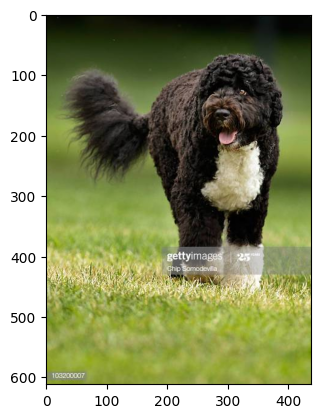

In [ ]:
make_prediction('valid/bo/bo_20.jpg')

9.213827133178711

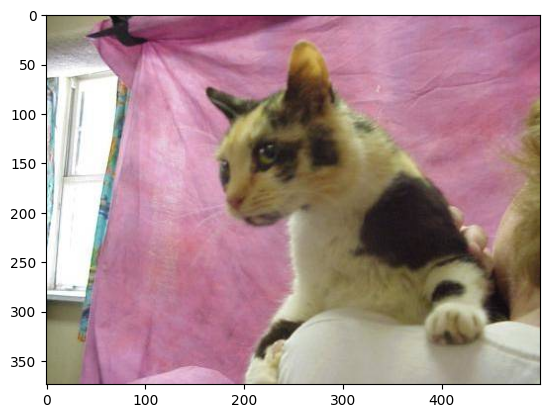

In [ ]:
make_prediction('valid/not_bo/121.jpg')

Parece que una predicción de número negativo significa que es Bo y una predicción de número positivo significa que es otra cosa. Podemos utilizar esta información para que nuestra puerta para perros sólo deje entrar a Bo.

## Ejercicio: Bo's Doggy Door

Rellena el siguiente código para implementar la puerta para perros de Bo:

In [ ]:
def presidential_doggy_door(image_path):
    pred = make_prediction(image_path)
    if pred <= 0.1:
        print("It's Bo! Let him in!")
    else:
        print("That's not Bo! Stay out!")

¡Vamos a probarlo!

That's not Bo! Stay out!


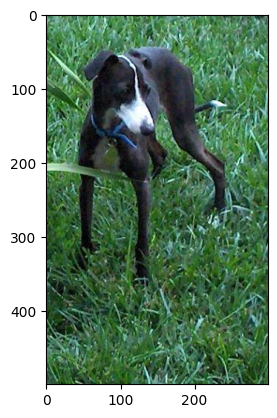

In [ ]:
presidential_doggy_door('valid/not_bo/131.jpg')

It's Bo! Let him in!


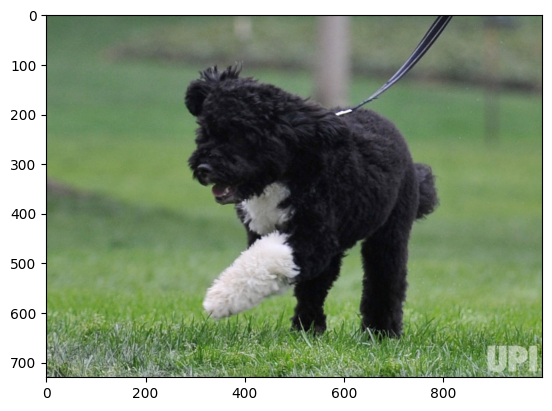

In [ ]:
presidential_doggy_door('valid/bo/bo_29.jpg')

That's not Bo! Stay out!


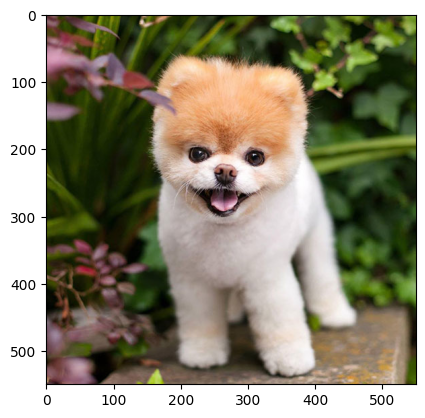

In [ ]:
presidential_doggy_door('boo.jpg')

It's Bo! Let him in!


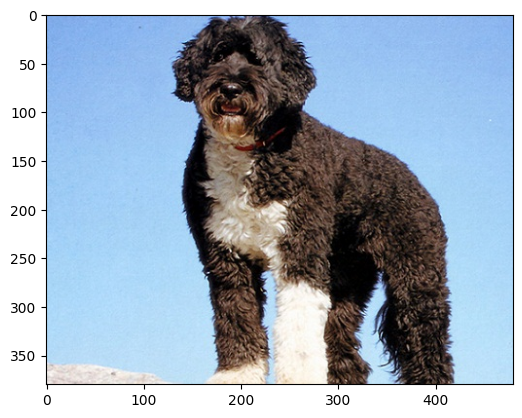

In [ ]:
presidential_doggy_door('boooooo.jpg')

It's Bo! Let him in!


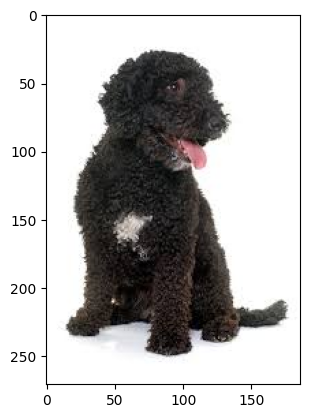

In [ ]:
presidential_doggy_door('booooo.jpg')

## Resumen

Buen trabajo. Con el aprendizaje por transferencia, has construido un modelo muy preciso utilizando un conjunto de datos muy pequeño. Puede ser una técnica muy poderosa y marcar la diferencia entre un proyecto de éxito y otro que no consigue despegar. Esperamos que estas técnicas puedan ayudarle en situaciones similares en el futuro.
En el [NVIDIA TAO Toolkit] (https://developer.nvidia.com/tlt-getting-started) hay una gran cantidad de recursos útiles para el aprendizaje por transferencia.

## Preguntas

1. ¿Qué es el aprendizaje por transferencia y en qué casos es especialmente útil?
2. Explica cómo se compara el aprendizaje por transferencia con aprender una nueva habilidad en el ámbito humano.
3. ¿Por qué es importante congelar las capas de un modelo preentrenado antes de añadir nuevas capas para una tarea específica?
4. ¿Qué función de pérdida es más adecuada para un problema de clasificación binaria, y por qué se utiliza en el caso de reconocimiento de Bo?
5. ¿Qué es el ajuste fino de un modelo y cuándo es recomendable aplicarlo?
6. ¿Cómo interpretar las predicciones del modelo para implementar una “puerta de perros” para Bo?